<a href="https://colab.research.google.com/github/JoaoGranja/CIFAR100_ImageClassification/blob/master/image_classification_main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
is_colab = True


# **Colab Preparation** 
Before handling the project, we need to install tensorflow/keras and pip packages. I also share my google drive to simplify the connection with my google drive account.



In [2]:
if is_colab:
    #Package Installation and share Google Drive
    !pip install --upgrade pip
    #!pip install --upgrade keras
    !pip install keras-resnet
    !pip install tensorflow==2.4.0
    !pip install tensorflow-gpu==2.4.0
    !pip install keras==2.4.0

    #!pip install --upgrade tensorflow_hub
    !pip install tensorflow_addons
    !pip install --quiet vit-keras

    from google.colab import drive
    drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


 # **Configuration and imports**

The first thing I need to do is to import all modules we need for this project. I also use some configuration parameters to provide more flexibility to the tranining process

In this project I will be making use of the Keras library for creating our model and training it. I will also use Matplotlib for visualizing our dataset to gain a better understanding of the images we are going to be handling.



In [3]:
# Generic Imports
import time
import gc
import logging, os
import sys
import random
import warnings
import pickle
from math import ceil
from tqdm import tqdm
from itertools import chain

# data processing and visualization library
import numpy as np
import pandas as pd
#import seaborn as sns
import matplotlib.pyplot as plt

# image procesing library
#from skimage.io import imread, imshow, imread_collection, concatenate_images
#from skimage.transform import resize
#from skimage.morphology import label
import cv2 

# tensorflow and keras for CNN model
import tensorflow as tf
logging.disable(logging.WARNING)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

from tensorflow.keras.models import Model, save_model, load_model, Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from tensorflow.keras.optimizers import RMSprop, Adam, SGD
from tensorflow.keras import backend as K
from tensorflow.keras.losses import categorical_crossentropy, sparse_categorical_crossentropy
from tensorflow.keras.datasets import cifar100
from tensorflow.keras.utils import to_categorical
#from keras.utils import multi_gpu_model
from tensorflow.keras.preprocessing.image import Iterator, load_img, img_to_array, ImageDataGenerator

if is_colab:
    from google.colab import files
    sys.path.append('/content/drive/MyDrive/colab/CIFAR100_Image_Classification')
    os.chdir('/content/drive/MyDrive/colab/CIFAR100_Image_Classification')
    
#------------------------------  Set some configuration parameters -----------------------------------#
args = {}
args['seed'] = 42
args['data_augmentation'] = True
args['training'] = False
args['fine_tuning'] = False
args['evaluation_networks'] = True

#training arguments
args['batch_size'] = 32
args['train_epochs'] = 10
args['fine_tune_epochs'] = 5
#args['validation_split'] = 0.2

#model arguments
args['compare_networks'] = ['vgg19', 'resnet50', 'efficientnetb0', 'efficientnetv2', 'vit-b32', 'vit_scratch']
args['network'] = 'vit_scratch'
args['models_dir'] = 'nn_models_checkpoints'

#optimizer arguments
args['optimizer'] = 'adam'
#args['weights'] = 'nn_models_checkpoints/best_{}.h5'.format(args['networks'][0])
args['learning_rate'] = 0.001
args['decay'] = 0.0001
args['loss'] = 'categorical_crossentropy'

# In this project I will also train a vit model from scratch. So I will use more epochs for training....
if args['network'] == 'vit_scratch':
  args['batch_size'] = 256
  args['train_epochs'] = 20  

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')

## Loading the dataset

In this project I will use the CIFAR100 dataset which is comprised of 60000 32x32 color images in 100 classes, with 600 images per class. There are 50000 training images and 10000 test images. More information is available on [CIFAR homepage](https://www.cs.toronto.edu/~kriz/cifar.html)

In [4]:
def unpickle(file):
    with open(file, 'rb') as data:
        dataset = pickle.load(data)
    return dataset

In [5]:
#------------------------------  Load dataset using keras.dataset API -----------------------------------#
download_dataset = True
if download_dataset:
    train_ds, test_ds = cifar100.load_data()
    dataset = {}
    dataset['train_ds'], dataset['test_ds'] = train_ds, test_ds
    with open('dataset/cifar100.pickle', 'wb') as output:
        pickle.dump(dataset, output)
else:
    dataset = unpickle('dataset/cifar100.pickle')
    train_ds, test_ds = dataset['train_ds'], dataset['test_ds']

#Check train and test dataset shape
x_train, y_train = train_ds
print("Train dataset: x={} y={}".format(x_train.shape, y_train.shape))
#Check number of classes and image shape
print("Image data shape =", x_train.shape[1:])
nr_classes = len(np.unique(y_train))
print("Number of classes =", nr_classes )
0
x_test, y_test = test_ds
print("Test dataset: x={} y={}".format(x_test.shape, y_test.shape))
   

Train dataset: x=(50000, 32, 32, 3) y=(50000, 1)
Image data shape = (32, 32, 3)
Number of classes = 100
Test dataset: x=(10000, 32, 32, 3) y=(10000, 1)


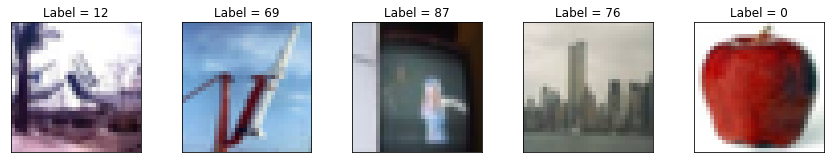

In [6]:
#------------------------------ Plot random images and respective labels -----------------------------------#
n_images = 5
fig, axs = plt.subplots(1, n_images, figsize=(12, 12))
fig.tight_layout(pad=1.0)
   
for i in range(n_images):
    index = random.randint(0, len(x_train))
    image = x_train[index].squeeze()

    axs[i].imshow(image)
    axs[i].set_title("Label = {0}".format(int(y_train[index])))
    axs[i].get_xaxis().set_visible(False)
    axs[i].get_yaxis().set_visible(False)


Analyzing the images it is clear that the images resolution is small, actually 32x32 has few pixels and therefore can be a challenge for a model to classify correctly the object. Furthermore all image has the same size so it is not required to resize the input images.

# **Data pre-processing and data augmentation**
The dataset output ranges from class 0 to 99. For training a model, it is easier to use a one hot encoding for the class element of each sample, in this way we transform any integer into a 100 element binary vector with a 1 for the index of the class value.

In order to improve the model generalization for new unseen images, I will also apply data augmentation process based on random transformations (rotation, image flip, image shift and zooming)

In [7]:
#------------------------------ Categorical Transformation  -----------------------------------#
y_train = to_categorical(y_train, nr_classes)
y_test = to_categorical(y_test, nr_classes)


#------------------------------ Random data augmentation -----------------------------------#
if args['data_augmentation']:
    train_datagen = ImageDataGenerator(
                        rotation_range=20,
                        width_shift_range=0.2,
                        height_shift_range=0.2,
                        zoom_range=0.2,
                        horizontal_flip=True)
                        #validation_split=args['validation_split'])
    # prepare iterator
    train_generator = train_datagen.flow(x_train, y_train, batch_size=args['batch_size']) #, subset='training')
    #validation_generator = train_datagen.flow(x_train, y_train, batch_size=args['batch_size'], subset='validation')
    
else:
    train_datagen = ImageDataGenerator()
    train_generator = train_datagen.flow(x_train, y_train, batch_size=args['batch_size'])
    #validation_generator = train_datagen.flow(x_train, y_train, batch_size=args['batch_size'], subset='validation')

test_datagen = ImageDataGenerator()
test_generator = test_datagen.flow(x_test, y_test, batch_size=args['batch_size'])


# **Optimizer**

Before training it is necessary to choose an optimizer which will be responsible to adjust model parameters in order to reduce the loss funcion

In [8]:
#------------------------------ Define an optimizer -----------------------------------#
if 'optimizer' in args:
    if args['optimizer'] == 'rmsprop':
        optimizer = RMSprop(learning_rate=args['learning_rate'], decay=float(args['decay']))
    elif args['optimizer'] == 'adam':
        optimizer = Adam(learning_rate=args['learning_rate'], decay=float(args['decay']))
    elif args['optimizer'] == 'amsgrad':
        optimizer = Adam(learning_rate=args['learning_rate'], decay=float(args['decay']), amsgrad=True)
    elif args['optimizer'] == 'sgd':
        optimizer = SGD(learning_rate=args['learning_rate'], momentum=0.9, nesterov=True, decay=float(args['decay']))
else:
    optimizer = RMSprop(learning_rate=args['learning_rate'])

# **Model**

In this project, I will use several Deep Learning Models for further comparison their performance. All models are defined on the separate module "models".

State of the art model architectures will be applied, such as VGG19, Resnet50, EfficientNet but also the most Deep Learning model architecture, ViT model.

To improve the results, transfer learning (mainly from Imagenet dataset checkpoints) will be used except for the 'vit_cratch' model, where as the name suggests, I will train a ViT model from scratch. 

When transfer learning is applied, the backbone model will be configured as not trainable to just train the last classifier for this specific dataset. After that a soft fine-tuning will be processed for the last backbone model layers.



In [9]:
from models.model_factory import make_model
import tensorflow_hub as hub
from models.ViT import Patches, PatchEncoder
from models.models import *

#------------------------------ Make the model -----------------------------------#
model = make_model(args['network'], x_train.shape[1:], nr_classes)

if 'weights' not in args:
    print('No weights passed, training from scratch')
else:
    print('Loading weights from {}'.format(args['weights']))
    model.load_weights(args['weights'], by_name=True)

#------------------------------ Compile the model -----------------------------------#
model.compile(loss=args['loss'], optimizer=optimizer, metrics=['accuracy']) 
model.summary()

No weights passed, training from scratch
Model: "vit_scratch"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 72, 72, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
patches (Patches)               (None, None, 108)    0           lambda[0][0]                     
__________________________________________________________________________________________________
patch_encoder (PatchEncoder)    (None, 144, 32)      8096        patches[0][0]                    
_______________________________________________

# **Training**

This step called training comprises on fitting the model parameters to classify correcty the images. For that, the optimizer uses a loss function to quantify the discrepance between true and predicted labels. Based on that it adjusts the model parameters to decrease the loss. 

Model checkpoints, EarlyStopping and Learning Rate reduce are used as callbacks to improce training efficiency.

In [10]:
#------------------------------ Model check points -----------------------------------#
best_model_file = '{}/best_{}.h5'.format(args['models_dir'], model.name)
last_model_file = '{}/last_{}.h5'.format(args['models_dir'], model.name)
model_file = '{}/model_{}.h5'.format(args['models_dir'], model.name)
history_name = '{}/history_{}.h5'.format(args['models_dir'], model.name)
#------------------------------ Callbacks -----------------------------------#

#ModelCheckpoint(filepath=last_model_file, monitor='val_loss', verbose=1, mode='min',
#            save_freq='epoch', save_best_only=False, save_weights_only=False)

callbacks = [
        # Callback to reduce the learning rate once the plateau has been reached:
        ReduceLROnPlateau(
            monitor='val_loss',
            min_delta=0.1,
            factor=1/3,
            patience=3,
            mode='auto',
            verbose=1,
            cooldown=0,
            min_lr=1e-8
        ),
        # Callback to stop the training once no more improvements are recorded:
        EarlyStopping(
            min_delta=0.001,
            verbose=1,
            patience=10,
            mode='auto',
            restore_best_weights=True
        ),
        # Callback to log the graph, losses and metrics into TensorBoard:
        #TensorBoard(log_dir="logs/{}".format(model.name)
        #),
        # Callback to save the best model specifying the epoch and val-loss in the filename:
        ModelCheckpoint(filepath=best_model_file, 
            monitor='val_loss',
            verbose=1,
            mode='min',
            save_freq='epoch',
            save_best_only=True,
            save_weights_only=False)
    ]
if args['training']:
    print("Training model {}".format(model.name))
    #------------------------------ Model Fit -----------------------------------#
    steps = len(x_train) // args['batch_size']
    history = model.fit(
                        train_generator,
                        steps_per_epoch=steps,
                        epochs=args['train_epochs'],
                        validation_data=test_generator,
                        callbacks=callbacks)

    #------------------------------ Save the last model weights -----------------------------------#
    model.save(model_file)
    print("Saved model to disk")
    with open(history_name, 'wb') as file_pi:
      pickle.dump(history.history, file_pi)

else:
  if args['network'] == 'vit_scratch': 
    model = load_model(model_file, custom_objects={'Patches':Patches, 'PatchEncoder':PatchEncoder})
  elif args['network'] == 'efficientnetv2': 
    model = load_model(model_file, custom_objects={'KerasLayer':hub.KerasLayer})
  else:
    model = load_model(model_file)

  if os.path.isfile(history_name):
    with open(history_name, 'rb') as data:
          history = pickle.load(data)

# **Fine tuning**

In the feature extraction experiment, you were only training a few layers on top of the pre-trained base model. The weights of the pre-trained network were not updated during training. 

One way to increase performance even further is to train (or "fine-tune") the weights of the top layers of the pre-trained model alongside the training of the classifier you added. The training process will force the weights to be tuned from generic feature maps to features associated specifically with the dataset. 

In fine-tune process, it is important to choose a small learning rate for the optimizer.

In [11]:
if args['fine_tuning']:
  if (args['network']  != 'vit_scratch'):
    base_model = model.get_layer(args['network'])
    base_model.trainable = True

  if (args['network']  in   ['vgg19', 'resnet50', 'efficientnetb0']):
    # Let's take a look to see how many layers are in the base model
    print("Number of layers in the base model: ", len(base_model.layers))

    # Fine-tune from this layer onwards
    fine_tune_at = len(base_model.layers) // 2

    # Freeze all the layers before the `fine_tune_at` layer
    for layer in base_model.layers[:fine_tune_at]:
      layer.trainable =  False

  #------------------------------ Compile the model -----------------------------------#
  model.compile(loss=args['loss'], optimizer=RMSprop(learning_rate=args['learning_rate']/100), metrics=['accuracy']) 
  model.summary()

  #------------------------------ Model Fit -----------------------------------#
  steps = len(x_train) // args['batch_size']
  total_epochs =  args['train_epochs'] + args['fine_tune_epochs']
  fine_tune_history = model.fit(
                      train_generator,
                      steps_per_epoch=steps,
                      epochs=total_epochs,
                      initial_epoch = args['train_epochs'],
                      validation_data=test_generator,
                      callbacks=callbacks)

  #------------------------------ Save the last model weights -----------------------------------#
  model.save(model_file)
  print("Saved model to disk")    


# **Visualise Model Results**

In [12]:
#------------------------------ Plot diagnostic learning curves -----------------------------------#
def summarize_diagnostics(history, model_name, fine_tune_history={}):
    # plot loss
    acc = history['accuracy']
    val_acc = history['val_accuracy']
    loss = history['loss']
    val_loss = history['val_loss']

    if args['fine_tuning']:
      acc += fine_tune_history['accuracy']
      val_acc += fine_tune_history['val_accuracy']

      loss += fine_tune_history['loss']
      val_loss += fine_tune_history['val_loss']  

    plt.figure(figsize=(8, 8))
    plt.subplot(2,1,1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.ylim([0.1, 1])
    if args['fine_tuning']:
      plt.plot([args['train_epochs'],args['train_epochs']],
          plt.ylim(), label='Start Fine Tuning')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2,1,2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    #plt.ylim([0, 10])
    if args['fine_tuning']:
      plt.plot([args['train_epochs'],args['train_epochs']],
          plt.ylim(), label='Start Fine Tuning')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    
    # save plot to file
    plt.savefig("results_" + model_name  + '_plot.png')
    plt.show()
    plt.close()

if args['evaluation_networks'] is False:
  if args['training']:  
    dict_history = history.history
  else:
    dict_history = history

  if args['fine_tuning']:
    summarize_diagnostics(dict_history, args['network'], fine_tune_history.history)
  else:
    summarize_diagnostics(dict_history, args['network'])

# **Evaluation**

Evaluate the model over the test dataset. We will use the last model weights and predict the class for some test images

----------------------- model vgg19 -----------------------
nn_models_checkpoints/model_vgg19.h5
Loaded model nn_models_checkpoints/model_vgg19.h5 from disk


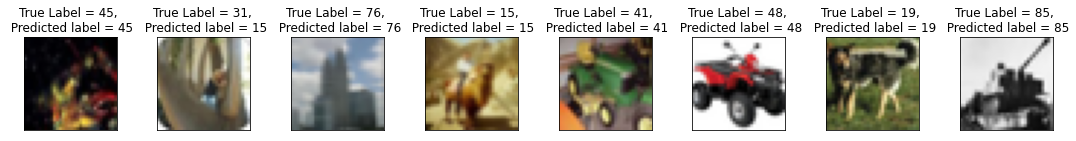

Testing accuracy of model VGG19 = 0.7462999820709229


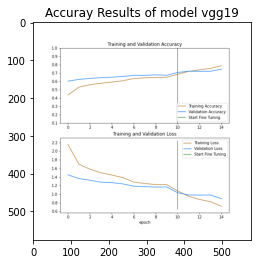

----------------------- model resnet50 -----------------------
nn_models_checkpoints/model_resnet50.h5
Loaded model nn_models_checkpoints/model_resnet50.h5 from disk


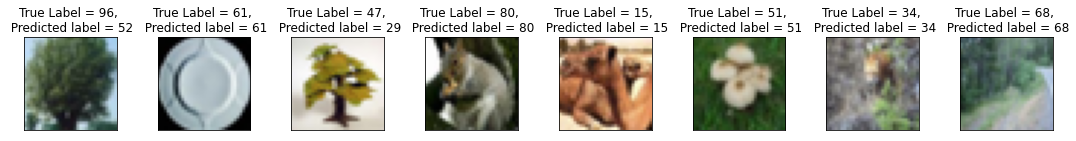

Testing accuracy of model resnet50 = 0.7835999727249146


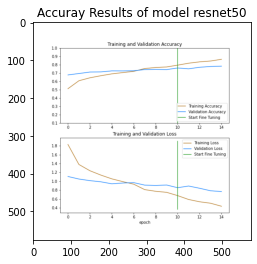

----------------------- model efficientnetb0 -----------------------
nn_models_checkpoints/model_efficientnetb0.h5
Loaded model nn_models_checkpoints/model_efficientnetb0.h5 from disk


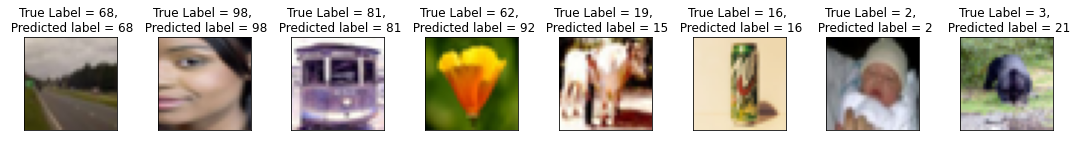

Testing accuracy of model efficientNetB0 = 0.7530999779701233


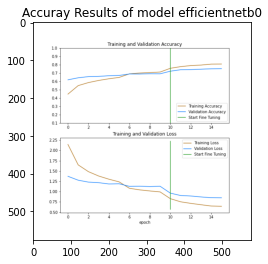

----------------------- model efficientnetv2 -----------------------
nn_models_checkpoints/model_efficientnetv2.h5
Loaded model nn_models_checkpoints/model_efficientnetv2.h5 from disk


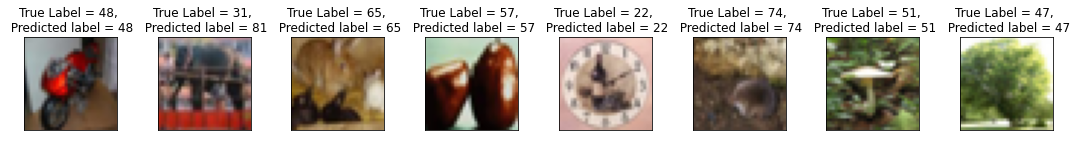

Testing accuracy of model efficientNetV2 = 0.7225000262260437


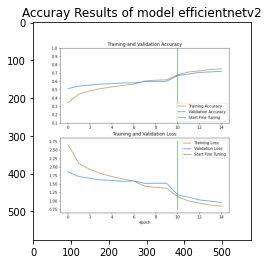

----------------------- model vit-b32 -----------------------
nn_models_checkpoints/model_vit-b32.h5
Loaded model nn_models_checkpoints/model_vit-b32.h5 from disk


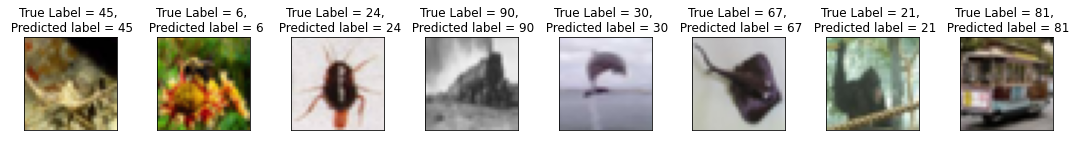

Testing accuracy of model ViT = 0.9100000262260437


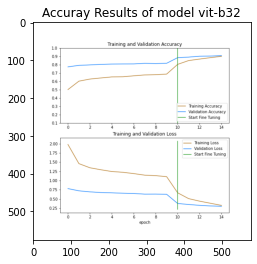

----------------------- model vit_scratch -----------------------
nn_models_checkpoints/model_vit_scratch.h5
Loaded model nn_models_checkpoints/model_vit_scratch.h5 from disk


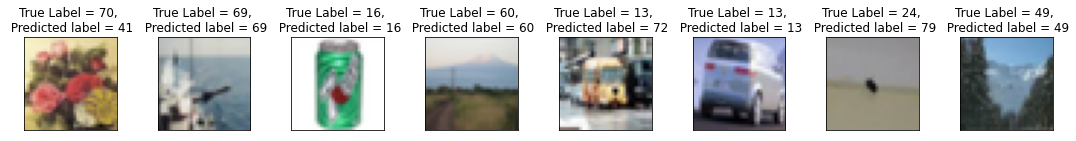

Testing accuracy of model vit_scratch = 0.36399999260902405


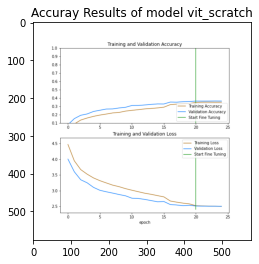

In [13]:
gc.collect

if args['evaluation_networks']:

  def show_image_prediction(loaded_model, n_images):
    #Try out the model on an image from the test data:
    #plt.figure(figsize=(30, 30))
    fig, axs = plt.subplots(1, n_images, figsize=(15, 15))
    fig.tight_layout(pad=1.0)

    # View the images
    for i in range(n_images):
        index = random.randint(0, len(x_test))
        image = x_test[index].squeeze()
        true_index = [i for i in range(nr_classes) if y_test[index][i] == 1 ][0]

        prediction_scores = loaded_model.predict(np.expand_dims(image, axis=0))
        predicted_index = np.argmax(prediction_scores)

        #image = np.add(image*128,128).astype(int)
        axs[i].imshow(image)
        axs[i].set_title("True Label = {0}, \n Predicted label = {1}".format(true_index, predicted_index))
        axs[i].get_xaxis().set_visible(False)
        axs[i].get_yaxis().set_visible(False)
    
    plt.show()
    plt.close()

  #------------------------------ Predict on some test images -----------------------------------#
  i=1

  for network in args['compare_networks']:
      print("----------------------- model {} -----------------------".format(network))


      #plt.subplot(1, len(args['networks']), i)
      #Load last model parameters
      model_file = '{}/model_{}.h5'.format(args['models_dir'], network)
      print(model_file)

      #Load the model
      if network == 'vit_scratch': 
        loaded_model = load_model(model_file, custom_objects={'Patches':Patches, 'PatchEncoder':PatchEncoder})
      elif network == 'efficientnetv2': 
        loaded_model = load_model(model_file, custom_objects={'KerasLayer':hub.KerasLayer})
      else:
        loaded_model = load_model(model_file)
      print("Loaded model {} from disk".format(model_file))
      loaded_model.compile(loss=args['loss'], optimizer=optimizer, metrics=['accuracy']) 

      #Try out the model on an image from the test data:
      show_image_prediction(loaded_model,8)

      #------------------------------ Evaluate model on testing dataset -----------------------------------#
      #_, acc = loaded_model.evaluate(x_train, y_train, verbose=0)
      #print("Training accuracy of model {0} = {1}".format(loaded_model.name, acc))
      _, acc = loaded_model.evaluate(x_test, y_test, verbose=0)
      print("Testing accuracy of model {0} = {1}".format(loaded_model.name, acc)) 

      #------------------------------ Plot all model results -----------------------------------#
      # save plot to file
      filename = "results_" + network + '_plot.png'
      im = cv2.imread(filename)
      plt.imshow(im)
      plt.title("Accuray Results of model {}".format(network))
      i = i + 1

      plt.show()
  plt.close()

Comparing the results obtained from the three models *LeNet*, *VGG16* and *VGG19*, it is possible to conclude the model with the best result is *VGG16* followed by *VGG19*. Indeed *VGG16* has the highest accuracy evaluated on testing dataset. Due to reduced capacity, *LeNet* starts overfiting earlier, actually the fine-tuning process didn't improve model results.

**Conclusion**

In this project I built from scratch a simple LeNet model and used 2 pre-trained models, VGG16 and VGG19. I train all models and evaluate the results against the CIFAR10 testing dataset. Taking into account the accuracy, the best model for this dataset was VGG16. 

So in this project, I applied several workflow steps to train a deep learning model on the image classification problem. In sume the steps were: pre-processing the input data, apply data-augmentation, build a CNN model, use pre-trained models, train a model, fine-tuning the model and evaluate the model. 

I used transfer learning technique on VGG16 and VGG19 models which is usefull when our dataset is not so large like in this case. The models accuracy on testing dataset is around 81/83% which are good results. 

For future work, I could apply better data augmentation in order to avoid overfitting as well as regularization techniques like L1 or L2. 